In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import time
from dateutil.relativedelta import *
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.max_rows', 100)

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot

import joblib

Importing plotly failed. Interactive plots will not work.


In [2]:
import os, sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')

### allows to direct changes in the packages to be immidiately visibe in the notebook 
%load_ext autoreload
%autoreload 2


In [3]:
file = '../data/index_price.csv'
df_quotes = pd.read_csv(file, sep = ';')
df_quotes.index = pd.to_datetime(df_quotes.Datetime)

ticker = '^GSPC'
df_data = df_quotes[df_quotes['Symbol']==ticker]

In [4]:
df_data.head()

,Datetime,Open,High,Low,Close,Volume,Symbol,Adj_Close
Datetime,,,,,,,,
2010-01-04 15:30:00,2010-01-04 15:30:00,1116.560059,1133.869995,1116.560059,1132.989990,3.991400e+09,^GSPC,1132.989990
2010-01-05 15:30:00,2010-01-05 15:30:00,1132.660034,1136.630005,1129.660034,1136.520020,2.491020e+09,^GSPC,1136.520020
2010-01-06 15:30:00,2010-01-06 15:30:00,1135.709961,1139.189941,1133.949951,1137.140015,4.972660e+09,^GSPC,1137.140015
2010-01-07 15:30:00,2010-01-07 15:30:00,1136.270020,1142.459961,1131.319946,1141.689941,5.270680e+09,^GSPC,1141.689941
2010-01-08 15:30:00,2010-01-08 15:30:00,1140.520020,1145.390015,1136.219971,1144.979980,4.389590e+09,^GSPC,1144.979980


In [5]:
df_price = pd.DataFrame()
df_price['ds'] = pd.to_datetime(df_data.Datetime)
df_price['y'] = df_data['Close']
df_price = df_price.reset_index(drop=True)
df_price

,ds,y
0,2010-01-04 15:30:00,1132.989990
1,2010-01-05 15:30:00,1136.520020
2,2010-01-06 15:30:00,1137.140015
3,2010-01-07 15:30:00,1141.689941
4,2010-01-08 15:30:00,1144.979980
...,...,...
2668,2020-08-10 15:30:00,3360.469971
2669,2020-08-11 15:30:00,3333.689941
2670,2020-08-12 15:30:00,3380.350098
2671,2020-08-13 15:30:00,3373.429932


In [6]:
test_window = 7 ### days
max_rows = df_price.shape[0]

df_train = df_price[0:max_rows-test_window]
df_test = df_price[max_rows-test_window:max_rows]
df_train.shape, df_test.shape

((2666, 2), (7, 2))

In [7]:
df_train.tail(test_window)

,ds,y
2659,2020-07-28 15:30:00,3218.439941
2660,2020-07-29 15:30:00,3258.439941
2661,2020-07-30 15:30:00,3246.219971
2662,2020-07-31 15:30:00,3271.120117
2663,2020-08-03 15:30:00,3294.610107
2664,2020-08-04 15:30:00,3306.510010
2665,2020-08-05 15:30:00,3327.770020


In [8]:
df_test.tail(test_window)

,ds,y
2666,2020-08-06 15:30:00,3349.159912
2667,2020-08-07 15:30:00,3351.280029
2668,2020-08-10 15:30:00,3360.469971
2669,2020-08-11 15:30:00,3333.689941
2670,2020-08-12 15:30:00,3380.350098
2671,2020-08-13 15:30:00,3373.429932
2672,2020-08-14 15:30:00,3372.850098


In [9]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=True)
df_prophet.fit(df_train)

In [10]:
fcast_time=test_window
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)

In [11]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [12]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-04 15:30:00,1128.733330,1017.506897,1248.426207
1,2010-01-05 15:30:00,1132.685715,1031.367951,1241.218902
2,2010-01-06 15:30:00,1132.784571,1019.960757,1238.977153
3,2010-01-07 15:30:00,1133.889024,1016.305907,1235.415526
4,2010-01-08 15:30:00,1135.309682,1025.527006,1244.475347
...,...,...,...,...
2668,2020-08-08 15:30:00,3083.843054,2975.323448,3193.896057
2669,2020-08-09 15:30:00,2961.984743,2849.768135,3068.670162
2670,2020-08-10 15:30:00,3107.279860,3002.979582,3217.275871
2671,2020-08-11 15:30:00,3107.535446,3000.518264,3214.259835


### Cross Validation

#### This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon. Checkout the source https://facebook.github.io/prophet/docs/diagnostics.html

![title](../data/diagnostics_3_0.png)

In [13]:
cutoffs = pd.to_datetime(['2020-07-23', '2020-08-01', '2018-08-15'])

In [14]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '14 days')

INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-02-25 15:30:00 and 2020-07-22 15:30:00


In [17]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
376,2020-07-30 15:30:00,3114.707554,3010.465909,3222.002343,3246.219971,2020-07-22 15:30:00
377,2020-07-31 15:30:00,3112.901688,3004.031733,3219.895283,3271.120117,2020-07-22 15:30:00
378,2020-08-03 15:30:00,3105.692670,3001.133212,3213.548760,3294.610107,2020-07-22 15:30:00
379,2020-08-04 15:30:00,3106.124081,2995.353238,3216.300242,3306.510010,2020-07-22 15:30:00
380,2020-08-05 15:30:00,3102.633426,2996.846280,3211.951709,3327.770020,2020-07-22 15:30:00


In [18]:
df_p = performance_metrics(df_cv)

In [19]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days 00:00:00,5680.853666,75.371438,46.773511,0.020461,0.015112,0.681174
1,2 days 23:00:00,5663.192682,75.254187,47.126214,0.020517,0.016454,0.686235
2,3 days 00:00:00,6640.232355,81.487621,50.124588,0.022620,0.013984,0.562753
3,3 days 23:00:00,6378.344252,79.864537,49.632274,0.022236,0.013984,0.582996
4,4 days 00:00:00,6412.384835,80.077368,48.592231,0.022318,0.013896,0.610526
5,4 days 23:00:00,5952.360137,77.151540,46.874789,0.021384,0.012218,0.648421
6,5 days 00:00:00,5817.899556,76.275157,48.314396,0.022566,0.014168,0.562753
7,5 days 23:00:00,5503.303078,74.184251,46.915276,0.021850,0.013518,0.582996
8,6 days 00:00:00,7473.123254,86.447228,58.610073,0.028067,0.017757,0.480549
9,6 days 23:00:00,7189.510699,84.790982,57.010876,0.027235,0.017757,0.508009


### Ploting

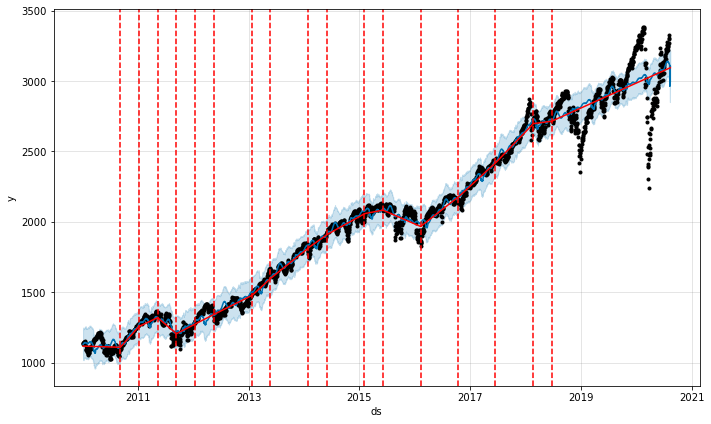

In [20]:
fig = df_prophet.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast)

### Adding seasonality, and by increasing changepoint_prior_scale, we got more flexible fit 

In [49]:
df_prophet = Prophet(changepoint_prior_scale=0.5, holidays=None, daily_seasonality=True,
                     weekly_seasonality=True, yearly_seasonality=True)

In [50]:
#### another method to add seasonality effect is via the fourior basis functions, change in the value of period will result in different seasonality effect
#df_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#df_prophet.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

In [51]:
df_prophet.fit(df_train)

In [52]:
fcast_time=test_window
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)

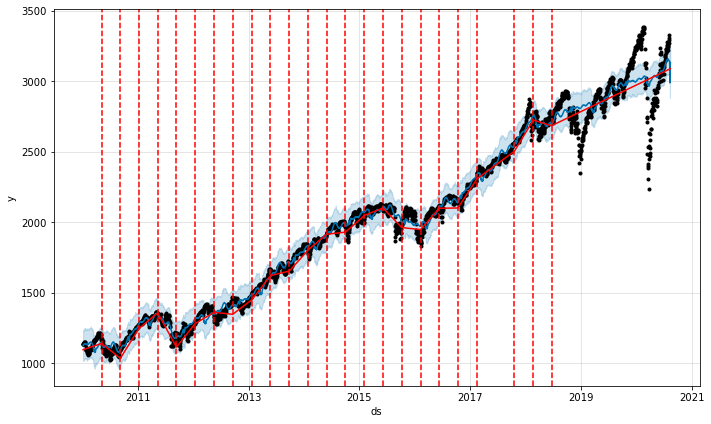

In [53]:
df_forecast = df_prophet.predict(df_forecast)
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig = df_prophet.plot(df_forecast)
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast)


#### Again test the results using CV

In [ ]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '14 days')
df_p = performance_metrics(df_cv)

# Hyper-parameter tuning

In [54]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range': [0.85, 0.90, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [ ]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_price)  # Fit model with given params
    df_cv = cross_validation(m,  initial='2600', period='100 days', horizon = '7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 39 forecasts with cutoffs between 2010-03-13 15:30:00 and 2020-08-07 15:30:00


In [ ]:
#df_p
#min(rmses)
#len(rmses)
#rmses

In [ ]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
#print(tuning_results)

#### Do argmax

In [51]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


In [266]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.95}

In [268]:
f = open("dict.txt","w")
f.write( str(best_params) )
f.close()

In [269]:
with open('dict.txt', 'r') as file:
    best_params = file.read().replace('\n', '')
    best_params = eval(best_params)


In [270]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'changepoint_range': 0.95}

In [272]:
mdl_prophet = Prophet(**best_params)

In [273]:
mdl_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
df_cv = cross_validation(mdl_prophet, initial='2600', period='100 days', horizon = '7 days')

In [274]:
fcast_time=9
df_forecast_w_history = mdl_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)
df_forecast_w_history = df_forecast_w_history[df_forecast_w_history['ds'].dt.dayofweek < 5]

# Forecasting

In [282]:

df_prophet = Prophet(changepoint_prior_scale= 0.5, seasonality_prior_scale= 0.1, 
                     seasonality_mode= 'multiplicative', changepoint_range= 0.95)

In [283]:
df_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
df_cv = cross_validation(df_prophet, initial='2600', period='100 days', horizon = '7 days')

In [55]:
df_p = performance_metrics(df_cv, rolling_window=0)

In [57]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,29231.361246,170.971814,129.465787,0.029123,0.022892,0.520000
1,2 days,26104.068155,161.567534,128.707590,0.030158,0.024116,0.538462
2,3 days,46843.964408,216.434665,144.646679,0.033760,0.021679,0.535714
3,4 days,51240.982147,226.364710,145.554085,0.033882,0.020953,0.592593
4,5 days,55430.393423,235.436602,163.172860,0.037572,0.022041,0.538462
5,6 days,60355.244069,245.673043,186.145078,0.042431,0.034571,0.428571
6,7 days,78252.600701,279.736663,222.741386,0.052308,0.045079,0.296296


### Forecasting with History

In [284]:
fcast_time=9
df_prophet_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=True)
df_forecast_w_history = df_forecast_w_history[df_forecast_w_history['ds'].dt.dayofweek < 5]

In [286]:
df_forecast_w_history = df_prophet.predict(df_forecast_w_history)
df_forecast_w_history[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-04 09:00:00,4011.718731,3767.503362,4263.216709
1,2010-01-05 09:00:00,4014.067283,3762.675867,4254.822008
2,2010-01-06 09:00:00,4012.226765,3756.969922,4261.871298
3,2010-01-07 09:00:00,4010.616702,3764.424837,4247.270846
4,2010-01-08 09:00:00,4010.556601,3787.483097,4257.302642
...,...,...,...,...
2710,2020-08-10 09:00:00,4418.542245,4188.346772,4657.439255
2711,2020-08-11 09:00:00,4409.967682,4182.812569,4637.611079
2712,2020-08-12 09:00:00,4397.005374,4153.031594,4639.292633
2713,2020-08-13 09:00:00,4384.591544,4148.878583,4630.235424


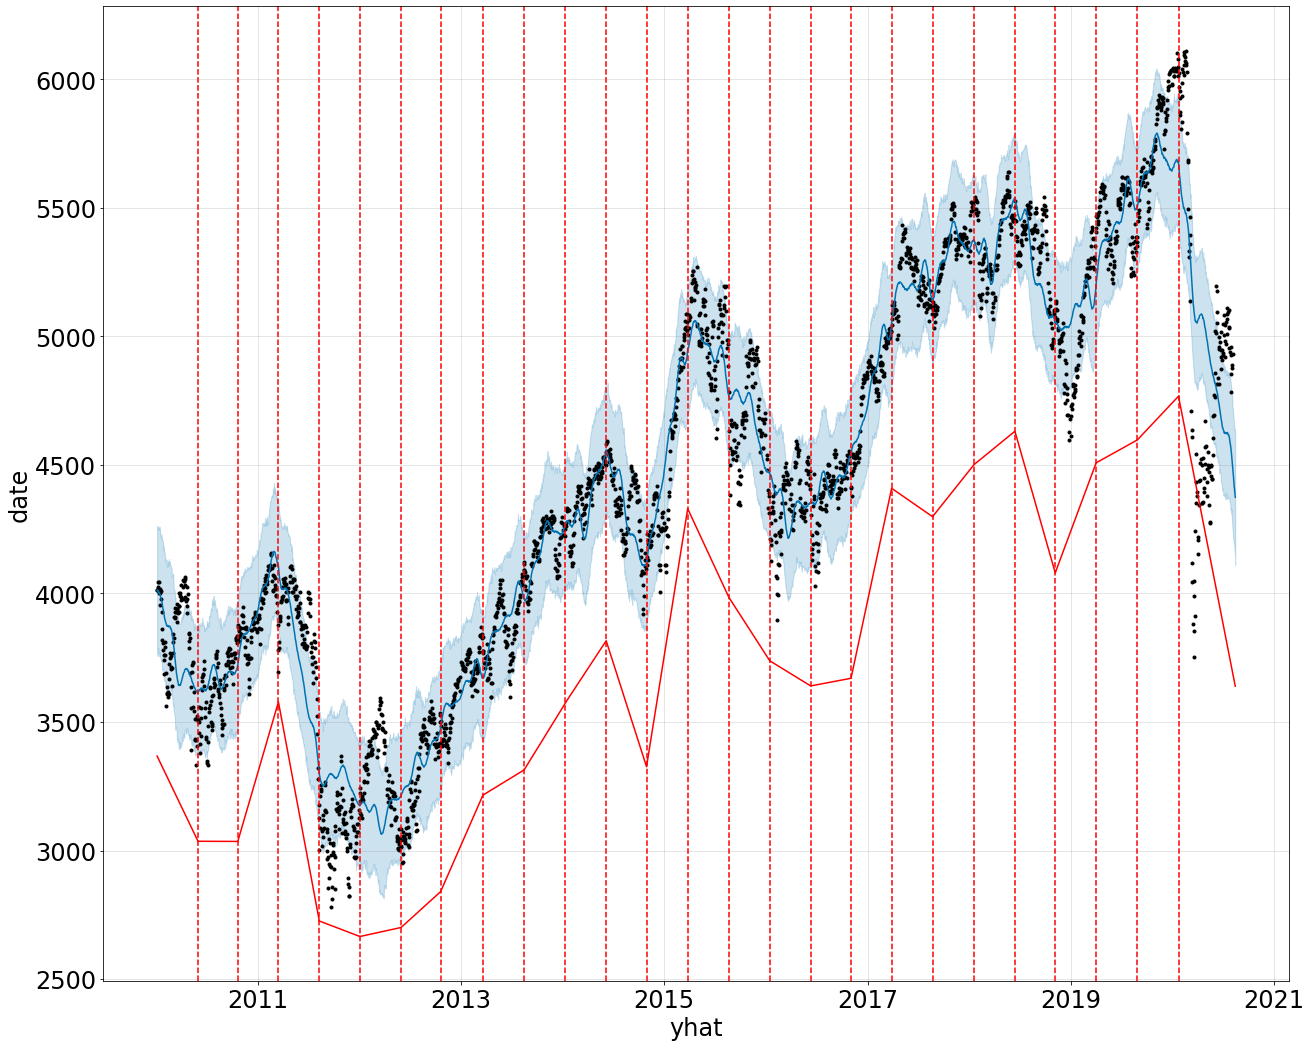

In [298]:
from matplotlib import pyplot as plt 

fig = df_prophet.plot(df_forecast_w_history)
fig.set_size_inches(20, 16)
plt.xlabel('yhat', fontsize=24)
plt.ylabel('date', fontsize=24)
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
a = add_changepoints_to_plot(fig.gca(), df_prophet, df_forecast_w_history)

In [299]:
fig.savefig('FBProphet_Forecast.png', bbox_inches='tight')

In [265]:
df_forecast_w_history.isna().sum()

ds                            0
trend                         0
yhat_lower                    0
yhat_upper                    0
trend_lower                   0
trend_upper                   0
multiplicative_terms          0
multiplicative_terms_lower    0
multiplicative_terms_upper    0
weekly                        0
weekly_lower                  0
weekly_upper                  0
yearly                        0
yearly_lower                  0
yearly_upper                  0
additive_terms                0
additive_terms_lower          0
additive_terms_upper          0
yhat                          0
dtype: int64

In [256]:
df_forecast_w_history.index = pd.to_datetime(df_forecast_w_history.ds)
df_forecast_w_history

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
2010-01-04 09:00:00,2010-01-04 09:00:00,3367.732865,3758.026969,4256.070487,3367.732865,3367.732865,0.191222,0.191222,0.191222,0.196385,0.196385,0.196385,-0.005163,-0.005163,-0.005163,0.0,0.0,0.0,4011.718731
2010-01-05 09:00:00,2010-01-05 09:00:00,3365.478571,3778.635084,4265.986766,3365.478571,3365.478571,0.192718,0.192718,0.192718,0.197530,0.197530,0.197530,-0.004811,-0.004811,-0.004811,0.0,0.0,0.0,4014.067283
2010-01-06 09:00:00,2010-01-06 09:00:00,3363.224277,3763.716759,4259.129104,3363.224277,3363.224277,0.192970,0.192970,0.192970,0.197398,0.197398,0.197398,-0.004428,-0.004428,-0.004428,0.0,0.0,0.0,4012.226765
2010-01-07 09:00:00,2010-01-07 09:00:00,3360.969983,3780.547067,4248.124433,3360.969983,3360.969983,0.193291,0.193291,0.193291,0.197321,0.197321,0.197321,-0.004029,-0.004029,-0.004029,0.0,0.0,0.0,4010.616702
2010-01-08 09:00:00,2010-01-08 09:00:00,3358.715689,3794.064734,4258.639483,3358.715689,3358.715689,0.194074,0.194074,0.194074,0.197709,0.197709,0.197709,-0.003634,-0.003634,-0.003634,0.0,0.0,0.0,4010.556601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10 09:00:00,2020-08-10 09:00:00,3661.505060,4177.104742,4662.580507,3661.505060,3661.505060,0.206756,0.206756,0.206756,0.196385,0.196385,0.196385,0.010371,0.010371,0.010371,0.0,0.0,0.0,4418.542245
2020-08-11 09:00:00,2020-08-11 09:00:00,3655.976474,4155.092844,4655.086558,3655.976474,3655.976474,0.206235,0.206235,0.206235,0.197530,0.197530,0.197530,0.008706,0.008706,0.008706,0.0,0.0,0.0,4409.967682
2020-08-12 09:00:00,2020-08-12 09:00:00,3650.447888,4155.465197,4646.083195,3650.447888,3650.447888,0.204511,0.204511,0.204511,0.197398,0.197398,0.197398,0.007113,0.007113,0.007113,0.0,0.0,0.0,4397.005374


In [261]:
df_price.loc[df_forecast_w_history.ds].y, df_forecast_w_history.yhat

(Datetime
 2010-01-04 09:00:00    4013.969971
 2010-01-05 09:00:00    4012.909912
 2010-01-06 09:00:00    4017.669922
 2010-01-07 09:00:00    4024.800049
 2010-01-08 09:00:00    4045.139893
                           ...     
 2020-08-10 09:00:00    4909.509766
 2020-08-11 09:00:00    5027.990234
 2020-08-12 09:00:00    5073.310059
 2020-08-13 09:00:00    5042.379883
 2020-08-14 09:00:00    4962.930176
 Name: y, Length: 2715, dtype: float64,
 ds
 2010-01-04 09:00:00    4011.718731
 2010-01-05 09:00:00    4014.067283
 2010-01-06 09:00:00    4012.226765
 2010-01-07 09:00:00    4010.616702
 2010-01-08 09:00:00    4010.556601
                           ...     
 2020-08-10 09:00:00    4418.542245
 2020-08-11 09:00:00    4409.967682
 2020-08-12 09:00:00    4397.005374
 2020-08-13 09:00:00    4384.591544
 2020-08-14 09:00:00    4374.282545
 Name: yhat, Length: 2715, dtype: float64)

In [262]:
mae = mean_absolute_error(df_price.loc[df_forecast_w_history.ds].y, df_forecast_w_history.yhat)
#df_forecast_w_history.yhat = df_forecast_w_history.yhat + mae

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Forecasting without History

In [301]:
fcast_time=9
df_forecast_wo_history = df_prophet.make_future_dataframe(periods= fcast_time, freq='D', include_history=False)
df_forecast_wo_history = df_forecast_wo_history[df_forecast_wo_history['ds'].dt.dayofweek < 5]
df_forecast_wo_history

,ds
0,2020-08-06 09:00:00
1,2020-08-07 09:00:00
4,2020-08-10 09:00:00
5,2020-08-11 09:00:00
6,2020-08-12 09:00:00
7,2020-08-13 09:00:00
8,2020-08-14 09:00:00


In [302]:
df_forecast_wo_history = df_prophet.predict(df_forecast_wo_history)
df_forecast_wo_history = df_forecast_wo_history[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast_wo_history.index = pd.to_datetime(df_forecast_wo_history.ds)
df_forecast_wo_history

,ds,yhat,yhat_lower,yhat_upper
ds,,,,
2020-08-06 09:00:00,2020-08-06 09:00:00,4474.285882,4231.482725,4727.392658
2020-08-07 09:00:00,2020-08-07 09:00:00,4462.610615,4232.299536,4709.301551
2020-08-10 09:00:00,2020-08-10 09:00:00,4418.542245,4156.125675,4665.418188
2020-08-11 09:00:00,2020-08-11 09:00:00,4409.967682,4171.867762,4637.144304
2020-08-12 09:00:00,2020-08-12 09:00:00,4397.005374,4163.747638,4645.419784
2020-08-13 09:00:00,2020-08-13 09:00:00,4384.591544,4134.168625,4624.774795
2020-08-14 09:00:00,2020-08-14 09:00:00,4374.282545,4127.419667,4611.690808


In [303]:
mae = mean_absolute_error(df_price.loc[df_forecast_wo_history.ds].y, df_forecast_wo_history.yhat)
df_forecast_wo_history.yhat = df_forecast_wo_history.yhat + mae

In [304]:
df_price.loc[df_forecast_wo_history.ds].y, df_forecast_wo_history.yhat

(Datetime
 2020-08-06 09:00:00    4885.129883
 2020-08-07 09:00:00    4889.520020
 2020-08-10 09:00:00    4909.509766
 2020-08-11 09:00:00    5027.990234
 2020-08-12 09:00:00    5073.310059
 2020-08-13 09:00:00    5042.379883
 2020-08-14 09:00:00    4962.930176
 Name: y, dtype: float64,
 ds
 2020-08-06 09:00:00    5027.069329
 2020-08-07 09:00:00    5015.394062
 2020-08-10 09:00:00    4971.325692
 2020-08-11 09:00:00    4962.751129
 2020-08-12 09:00:00    4949.788822
 2020-08-13 09:00:00    4937.374992
 2020-08-14 09:00:00    4927.065993
 Name: yhat, dtype: float64)

In [305]:
mean_squared_error(df_price.loc[df_forecast_wo_history.ds].y, df_forecast_wo_history.yhat)

10234.027641531455

In [306]:
2*np.std(df_price.loc[df_forecast_wo_history.ds])

y            144.743346
predictor      0.699854
dtype: float64

In [318]:
df_price['daily_returns'] = df_price.y.pct_change()*100
df_price['daily_returns_1'] = df_price['daily_returns'].shift(-1)
df_price['predictor'] = np.where( df_price.daily_returns_1 >= pred_threshold, 1, 0) 
df_price = df_price.drop(['daily_returns_1', 'daily_returns'], axis=1)
df_price
df_price.loc[df_forecast.ds]

,ds,y,predictor
Datetime,,,
2020-08-06 09:00:00,2020-08-06 09:00:00,4885.129883,0
2020-08-07 09:00:00,2020-08-07 09:00:00,4889.520020,0
2020-08-10 09:00:00,2020-08-10 09:00:00,4909.509766,1
2020-08-11 09:00:00,2020-08-11 09:00:00,5027.990234,0
2020-08-12 09:00:00,2020-08-12 09:00:00,5073.310059,0
2020-08-13 09:00:00,2020-08-13 09:00:00,5042.379883,0
2020-08-14 09:00:00,2020-08-14 09:00:00,4962.930176,0


In [320]:
df_forecast_wo_history['daily_returns'] = df_forecast_wo_history.yhat.pct_change()*100
df_forecast_wo_history['daily_returns_1'] = df_forecast_wo_history['daily_returns'].shift(-1)
df_forecast_wo_history.ds = pd.to_datetime(df_forecast_wo_history.ds)
df_forecast_wo_history.index = pd.to_datetime(df_forecast_wo_history.ds)


df_forecast_wo_history['predictor'] = np.where( df_forecast_wo_history.daily_returns_1 >= pred_threshold, 1, 0) 
df_forecast_wo_history = df_forecast_wo_history.drop(['daily_returns_1', 'daily_returns'], axis=1)

(df_forecast_wo_history, df_price.loc[df_forecast_wo_history.index])

(                                     ds         yhat   yhat_lower  \
 ds                                                                  
 2020-08-06 09:00:00 2020-08-06 09:00:00  5027.069329  4231.482725   
 2020-08-07 09:00:00 2020-08-07 09:00:00  5015.394062  4232.299536   
 2020-08-10 09:00:00 2020-08-10 09:00:00  4971.325692  4156.125675   
 2020-08-11 09:00:00 2020-08-11 09:00:00  4962.751129  4171.867762   
 2020-08-12 09:00:00 2020-08-12 09:00:00  4949.788822  4163.747638   
 2020-08-13 09:00:00 2020-08-13 09:00:00  4937.374992  4134.168625   
 2020-08-14 09:00:00 2020-08-14 09:00:00  4927.065993  4127.419667   
 
                       yhat_upper  predictor  
 ds                                           
 2020-08-06 09:00:00  4727.392658          0  
 2020-08-07 09:00:00  4709.301551          0  
 2020-08-10 09:00:00  4665.418188          0  
 2020-08-11 09:00:00  4637.144304          0  
 2020-08-12 09:00:00  4645.419784          0  
 2020-08-13 09:00:00  4624.774795      

In [321]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [333]:
f1_score(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor)


0.0

In [331]:
np.round(precision_score(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor), 2)*100

0.0

In [332]:
np.round(recall_score(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor), 2)*100

0.0

In [330]:
print(confusion_matrix(df_forecast_wo_history.predictor, df_price.loc[df_forecast_wo_history.index].predictor ))

[[6 1]
 [0 0]]


In [316]:
df_forecast_wo_history

,ds,yhat,yhat_lower,yhat_upper,predictor
ds,,,,,
2020-08-06 09:00:00,2020-08-06 09:00:00,5027.069329,4231.482725,4727.392658,0
2020-08-07 09:00:00,2020-08-07 09:00:00,5015.394062,4232.299536,4709.301551,0
2020-08-10 09:00:00,2020-08-10 09:00:00,4971.325692,4156.125675,4665.418188,0
2020-08-11 09:00:00,2020-08-11 09:00:00,4962.751129,4171.867762,4637.144304,0
2020-08-12 09:00:00,2020-08-12 09:00:00,4949.788822,4163.747638,4645.419784,0
2020-08-13 09:00:00,2020-08-13 09:00:00,4937.374992,4134.168625,4624.774795,0
2020-08-14 09:00:00,2020-08-14 09:00:00,4927.065993,4127.419667,4611.690808,0


### Save the Model

In [68]:
with open("Models/FCHI_FBPROPHET_PT_1_BUY.pkl", "wb") as f:
     joblib.dump(df_prophet, f)

In [69]:
mdl_pickle = joblib.load('Models/FCHI_FBPROPHET_PT_1_BUY.pkl')